# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 18.02.2025

Мягкий дедлайн: 11.03.2025 23:59 MSK

Жёсткий дедлайн: 16.03.2025 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/60281

Username — ваша фамилия и имя на латинице именно в таком порядке

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [1]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [2]:
L = np.load('L.npy')
n, m = L.shape

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои.

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [33]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [54]:
from scipy.special import expit
from scipy.special import logsumexp

def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    alpha_beta = alpha[np.newaxis, :]*beta[:, np.newaxis]

    log_likelihood_z0 = np.sum((L == 0)*(-softplus(-alpha_beta)) + (L == 1)*(-softplus(alpha_beta)), axis=1)
    log_likelihood_z1 = np.sum((L == 1)*(-softplus(-alpha_beta)) + (L == 0)*(-softplus(alpha_beta)), axis=1)

    log_post = np.vstack([log_likelihood_z0, log_likelihood_z1]) + np.log(0.5)

    posterior = np.exp(log_post - logsumexp(log_post, axis=0, keepdims=True))

    return posterior


def log_likelihood(alpha, beta, L, z):
    """ p(l=z|z, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        z: ndarray of shape (n_problems).
    """
    alpha_beta = alpha[np.newaxis, :]*beta[:, np.newaxis]

    log_likelihood = np.sum((L == z[:, np.newaxis])*(-softplus(-alpha_beta)) + (L != z[:, np.newaxis])*(-softplus(alpha_beta)))

    return log_likelihood


def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    alpha_beta = alpha[np.newaxis, :] * beta[:, np.newaxis]

    grad = np.sum(q[0, :, np.newaxis]*beta[:, np.newaxis] * ((L == 0)*expit(-alpha_beta) - (L == 1)*expit(alpha_beta)) +
        q[1, :, np.newaxis]*beta[:, np.newaxis] * ((L == 1)*expit(-alpha_beta) - (L == 0)*expit(alpha_beta)), axis=0)

    return grad


def logbeta_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    alpha_beta = alpha[np.newaxis, :] * beta[:, np.newaxis]

    grad = np.sum(q[0, :, np.newaxis] * alpha[np.newaxis, :]*((L == 0)*expit(-alpha_beta) - (L == 1)*expit(alpha_beta)) +
        q[1, :, np.newaxis] * alpha[np.newaxis, :] * ((L == 1)*expit(-alpha_beta) - (L == 0)*expit(alpha_beta)), axis=1)

    return grad


def lower_bound(alpha, beta, L, q):
    """ Lower bound
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    alpha_beta = alpha[np.newaxis, :] * beta[:, np.newaxis]

    lower_bound = np.sum(q[0, :, np.newaxis] * ((L == 0)*(-softplus(-alpha_beta)) + (L == 1)*(-softplus(alpha_beta))) +
        q[1, :, np.newaxis] * ((L == 1)*(-softplus(-alpha_beta)) + (L == 0)*(-softplus(alpha_beta))))

    return lower_bound

In [97]:
def em(L, n_steps=100, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(logbeta))) * 0.5

    for step in range(n_steps):
        q = posterior(alpha, np.exp(logbeta), L)

        alpha_grad = alpha_grad_lb(alpha, np.exp(logbeta), L, q)
        logbeta_grad = logbeta_grad_lb(alpha, np.exp(logbeta), L, q)
        alpha += lr * alpha_grad
        logbeta += lr * logbeta_grad

        print(f"Lower Bound на шаге {step}: {lower_bound(alpha, np.exp(logbeta), L, q)}")

    return alpha, np.exp(logbeta), q

In [102]:
alpha, beta, q = em(L)

Lower Bound на шаге 0: -28481.579766481995
Lower Bound на шаге 1: -22428.97125395358
Lower Bound на шаге 2: -21976.559380479986
Lower Bound на шаге 3: -21859.465372583392
Lower Bound на шаге 4: -21787.135693718978
Lower Bound на шаге 5: -21735.591732266217
Lower Bound на шаге 6: -21693.71198097042
Lower Bound на шаге 7: -21657.09726295599
Lower Bound на шаге 8: -21623.857066627832
Lower Bound на шаге 9: -21592.195767216162
Lower Bound на шаге 10: -21562.022903070334
Lower Bound на шаге 11: -21532.307134757924
Lower Bound на шаге 12: -21503.35400411082
Lower Bound на шаге 13: -21474.47519279759
Lower Bound на шаге 14: -21446.028589228776
Lower Bound на шаге 15: -21417.521615038564
Lower Bound на шаге 16: -21389.275874136172
Lower Bound на шаге 17: -21360.9266135995
Lower Bound на шаге 18: -21332.74039926471
Lower Bound на шаге 19: -21304.44327552533
Lower Bound на шаге 20: -21276.247872532636
Lower Bound на шаге 21: -21247.948294377635
Lower Bound на шаге 22: -21219.709729823855
Lower B

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$).

In [89]:
y = np.load('y.npy')
mask = np.sum(L, axis = 1) > 10
accuracy = np.mean(y == mask)
accuracy

0.904

In [103]:
(np.argmax(q, axis = 0) == y).mean()

0.956

**Вывод:** EM-алгоритм оказался намного лучше, чем обычное голосование по большинству среди экспертов, так как accuracy выросло на 0.05.

**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли врено размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

**Ответ:** в данной модели $\alpha$ показывает уровень экспертизы, поэтому если $\alpha$ принимает значение сильно ниже нуля, то даже при $\beta$ стремящейся к бесконечности (то есть задача очень легкая), вероятность снизу будет равна нулю, так как $\alpha$ меняет знак в степени экспоненты. Следовательно, такие эксперты намеренно голосуют неверно.

$p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) = \sigma(\alpha_j\beta_i) = 1/(1+exp(-\alpha_j\beta_i))$




In [104]:
experts_true_predicts = np.sum(L == y.reshape(-1, 1), axis = 0)
experts_accuracy = experts_true_predicts/len(y)

In [105]:
print('Верно проголосовали:', np.sum(experts_true_predicts))
print('Всего голосов:', len(beta)*len(alpha))

Верно проголосовали: 25456
Всего голосов: 40000


**Вывод:** Ну вроде как эксперты чаще голосуют ВЕРНО.

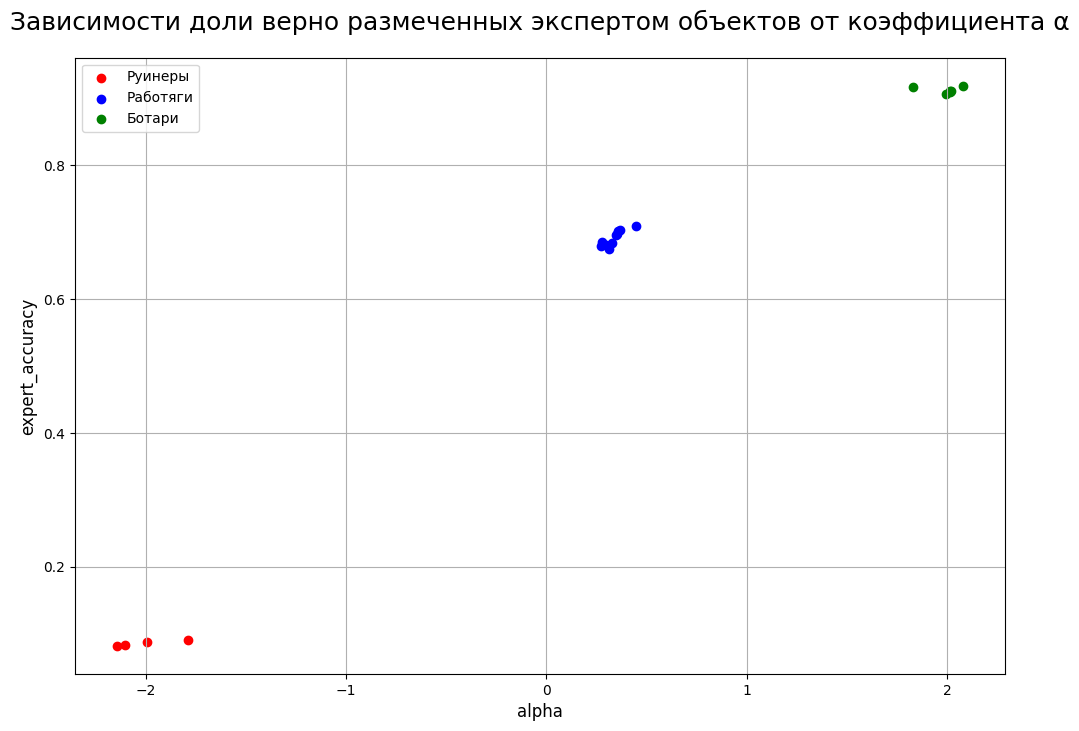

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

mask_negative = alpha < -1
mask_normal = (alpha >= -1) & (alpha <= 1)
mask_positive = alpha >= 1

plt.scatter(alpha[mask_negative], experts_accuracy[mask_negative], color='red', label='Руинеры')
plt.scatter(alpha[mask_normal], experts_accuracy[mask_normal], color='blue', label='Работяги')
plt.scatter(alpha[mask_positive], experts_accuracy[mask_positive], color='green', label='Ботари')

plt.xlabel('alpha', fontsize=12)
plt.ylabel('expert_accuracy', fontsize=12)
plt.title('Зависимости доли верно размеченных экспертом объектов от коэффициента α',  fontsize=18, pad=20)
plt.legend()
plt.grid(True)

plt.show()

**Вывод:** На графике отчетливо наблюдаются три группы: *зеленые* - хорошо справляются с работой, *синие* - нормально справляются с работой, но у них чаще бывают ошибки, чем у зеленых, и *красные* (4 человека) - они намеренно голосуют неверно.

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

In [136]:
def posterior_known(alpha, beta, L, known_labels=None):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    alpha_beta = alpha[np.newaxis, :]*beta[:, np.newaxis]

    log_likelihood_z0 = np.sum((L == 0)*(-softplus(-alpha_beta)) + (L == 1)*(-softplus(alpha_beta)), axis=1)
    log_likelihood_z1 = np.sum((L == 1)*(-softplus(-alpha_beta)) + (L == 0)*(-softplus(alpha_beta)), axis=1)

    log_post = np.vstack([log_likelihood_z0, log_likelihood_z1]) + np.log(0.5)

    if known_labels is not None:
        log_post[0, ~np.isnan(known_labels)] = np.where(known_labels[~np.isnan(known_labels)] == 0, 0, -np.inf)
        log_post[1, ~np.isnan(known_labels)] = np.where(known_labels[~np.isnan(known_labels)] == 1, 0, -np.inf)

    posterior = np.exp(log_post - logsumexp(log_post, axis=0, keepdims=True))

    return posterior

In [122]:
def em_known(L, known_labels, n_steps=100, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(logbeta))) * 0.5

    for step in range(n_steps):
        q = posterior_known(alpha, np.exp(logbeta), L,  known_labels=known_labels)

        alpha_grad = alpha_grad_lb(alpha, np.exp(logbeta), L, q)
        logbeta_grad = logbeta_grad_lb(alpha, np.exp(logbeta), L, q)
        alpha += lr * alpha_grad
        logbeta += lr * logbeta_grad

    return alpha, np.exp(logbeta), q

In [281]:
#Случайным образом выбираем вопросы с заведомо известной меткой
known_indices = np.random.choice(len(y), size=1000, replace=False)

known_labels = np.full_like(y, np.nan, dtype=float)
known_labels[known_indices] = y[known_indices]

In [288]:
alpha, beta, q = em_known(L, known_labels)

In [290]:
(np.argmax(q, axis = 0) == y).mean()

0.98

In [172]:
#Функция, которая считает acuuracy без учета вопросов с заведомо известной меткой
def calculate_accuracy(q, y):
    known_mask = ~np.isnan(known_labels)
    predicted_labels = np.argmax(q, axis=0)
    accuracy = (predicted_labels[~known_mask] == y[~known_mask]).mean()
    return accuracy

In [289]:
calculate_accuracy(q, y)

0.96

In [395]:
#Случайным образом выбираем вопросы с заведомо известной меткой
known_indices = np.random.choice(len(y), size=200, replace=False)

known_labels = np.full_like(y, np.nan, dtype=float)
known_labels[known_indices] = y[known_indices]

In [398]:
alpha, beta, q = em_known(L, known_labels)

In [399]:
calculate_accuracy(q, y)

0.955

In [400]:
#Случайным образом выбираем вопросы с заведомо известной меткой
known_indices = np.random.choice(len(y), size=100, replace=False)

known_labels = np.full_like(y, np.nan, dtype=float)
known_labels[known_indices] = y[known_indices]

In [431]:
alpha, beta, q = em_known(L, known_labels)

In [432]:
calculate_accuracy(q, y)

0.9536842105263158

**Вывод:** accuracy с учетом известных заданий выросло, что логично, так как на некоторые вопросы мы уже знаем ответы, следовательно в них не ошибаемся. Если считать accuracy, которое не учитывает известные задания, то оно может быть как выше, так и ниже, но несильно.

Также я заметил, что чем больше вопросов заранее известно, тем меньше вероятность, что нашей модели неважно какой класс 1, а какой 0, то есть accuracy всегда > 0.95, и не нужно менять метки. Так что данная модификация позволяет пресекать экспертов, которые заведомо ставят неверные метки.

# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно).

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [ ]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

https://contest.yandex.ru/contest/60281/run-report/134992882/

In [ ]:
import glob
from preprocessing import extract_sentences

all_sentences = []
all_targets = []
for file in glob.glob('/content/data/merged_data/*/*.wa'):
    sentences, targets = extract_sentences(file)
    all_sentences += sentences
    all_targets += targets

**Задание -1. (0.5 балла)** Реализуйте функции get_token_to_index и tokenize_sents из модуля preprocessing.py, постройте словари token->index для обоих языков и постройте список из TokenizedSentencePair по выборке. Реализации функций также отправьте в Яндекс.Контест.

https://contest.yandex.ru/contest/60281/run-report/134993121/

In [ ]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности.

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [ ]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая.

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели.

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

https://contest.yandex.ru/contest/60281/run-report/134993316/

In [ ]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8074618330841489

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

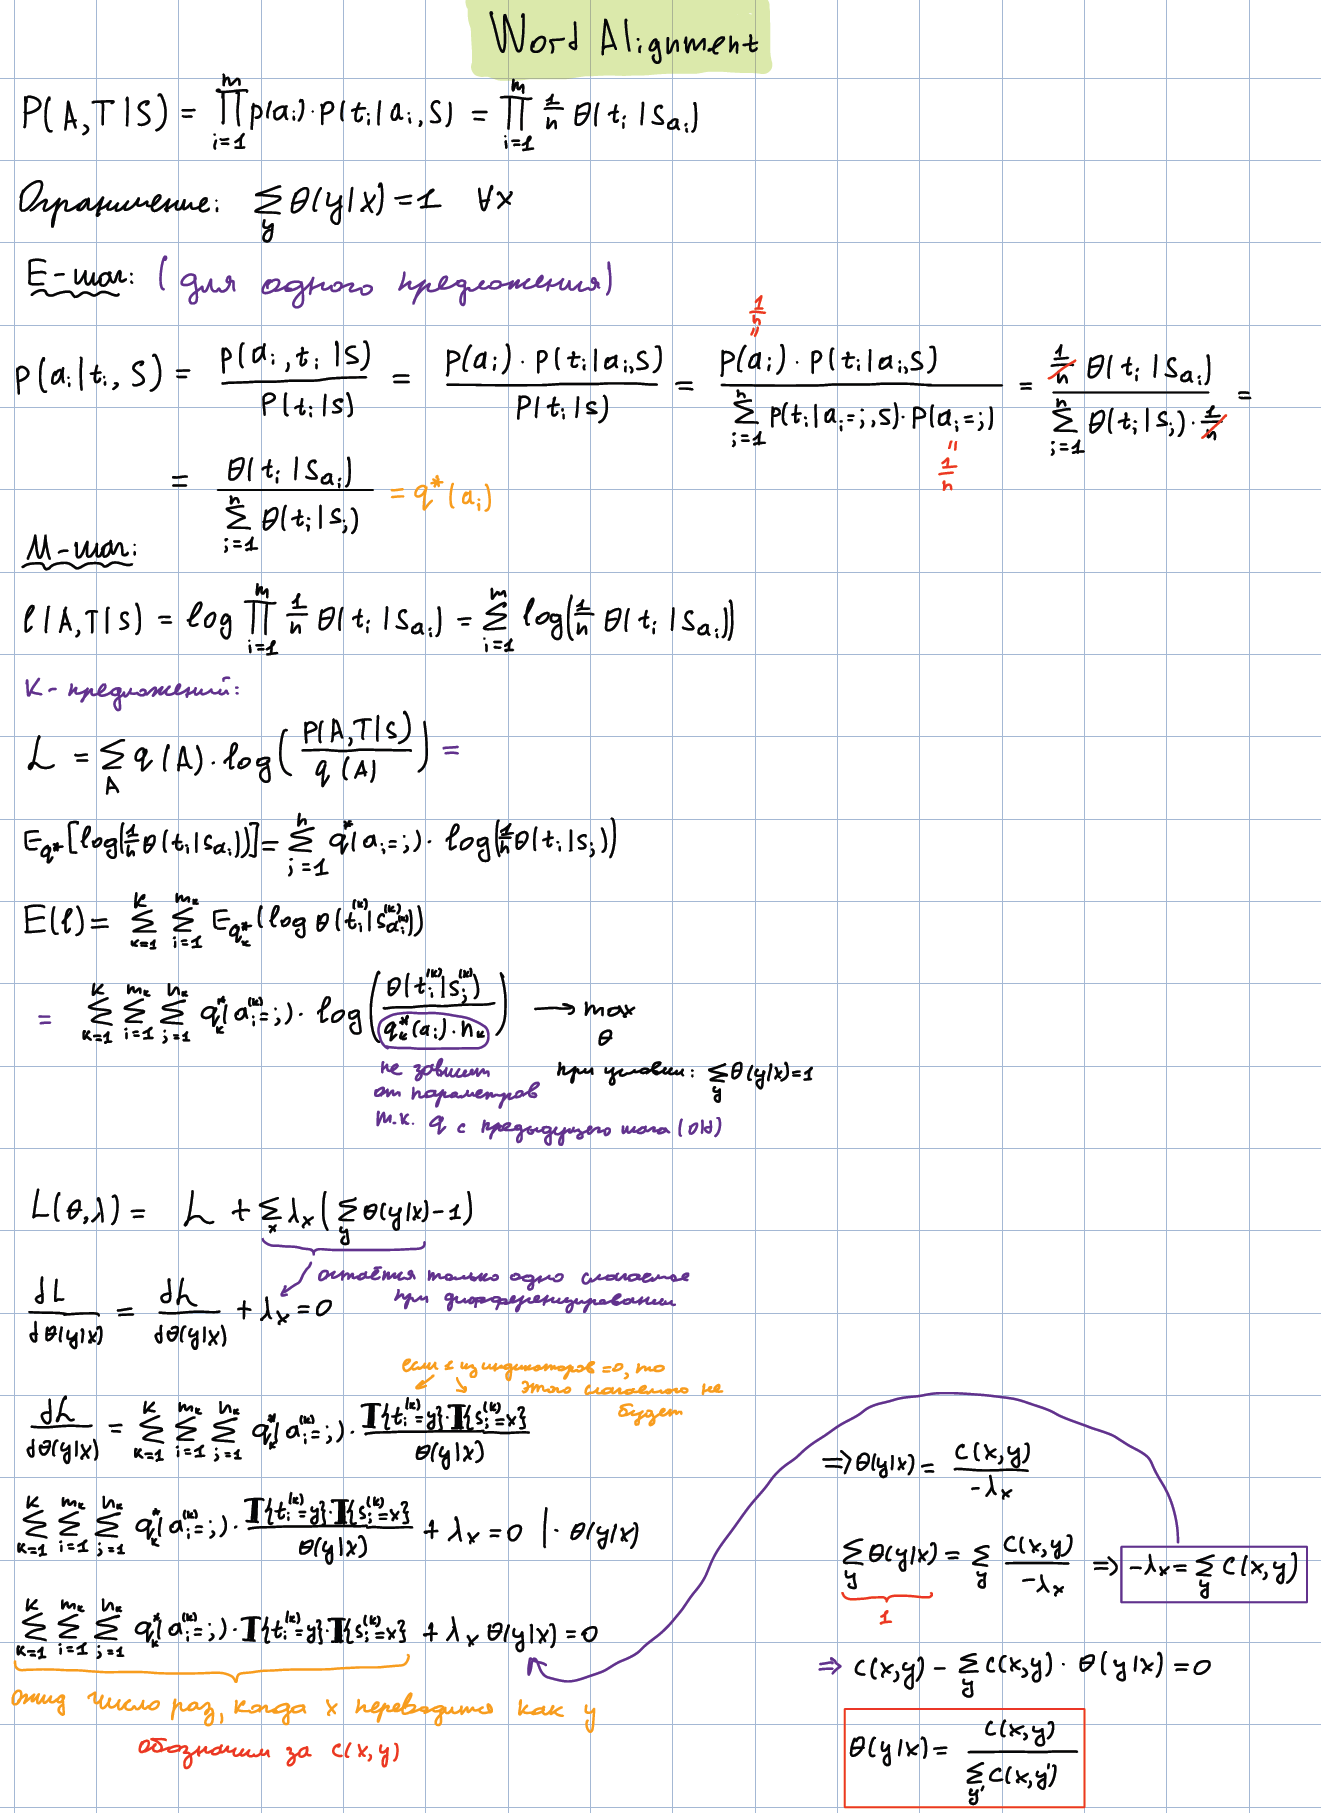

**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

https://contest.yandex.ru/contest/60281/run-report/135002621/

In [ ]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 10)

start_time = time.time()
word_aligner.fit(tokenized_sentences)
end_time = time.time()

In [ ]:
predict_alignments = word_aligner.align(tokenized_sentences)
print('Время обучения (сек):', round(end_time-start_time, 2))

Время обучения (сек): 4.71


In [ ]:
compute_aer(all_targets, predict_alignments)

0.577269406110751

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [ ]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

[',', 'řekl', 'pan']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['překupničením', 'záviselo', 'koni']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['se', '.', 'na']

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

**Ответ:** Мы можем получить вероятности перевода целевого языка в исходный с помощью формулы Байеса:

$$
\theta(s \mid t) = \frac{\theta(t \mid s) \cdot \theta(s)}{\theta(t)}
$$

Как видно, здесь фигурирует полученная нами матрица $\theta(t \mid s)$ , а также статистики по паралельному корпусу $\theta(s)$ и $\theta(t)$ - частоты слов $s$ и $t$ по всему корпусу.

In [ ]:
# Делаем подсчет слов из source и target
source_tokens = []
target_tokens = []

for pair in all_sentences:
    source_tokens.extend(pair.source)
    target_tokens.extend(pair.target)

source_counted = Counter(source_tokens)
target_counted = Counter(target_tokens)

In [ ]:
# Находим частоты для source
source_freqs = np.zeros(len(t_idx_src))

for token, idx in t_idx_src.items():
    source_freqs[idx] = source_counted.get(token, 0)

source_freqs /= np.sum(source_freqs)

In [ ]:
# Находим частоты для target
target_freqs = np.zeros(len(t_idx_tgt))

for token, idx in t_idx_tgt.items():
    target_freqs[idx] = target_counted.get(token, 0)

target_freqs /= np.sum(target_freqs)

In [ ]:
# Получаем вероятности перевода целевого языка в исходный по формуле Байеса
reverse_translation_probs = (word_aligner.translation_probs * source_freqs.reshape(-1, 1) / target_freqs.reshape(1, -1)).T

In [ ]:
idx_token_src = {index:token for token, index in t_idx_src.items()}

In [ ]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['kůň']].argsort()[-3:]]

['animal', 'demonstrated', 'horse']

In [ ]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['vítězství']].argsort()[-3:]]

['1871', 'victories', 'victory']

In [ ]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['postel']].argsort()[-3:]]

['every', 'sharp', 'bed']

In [ ]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['umístění']].argsort()[-3:]]

['correspondent', 'Ministry', 'location']

In [ ]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['práce']].argsort()[-3:]]

['lot', 'labor', 'work']

**Замечание:** Последнее слово списков - самое вероятное

**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_heatmaps(index):
    sentences = tokenized_sentences[index]
    predict_alignment = predict_alignments[index]

    # Создаем матрицу для варавниваний для предложений (для первого графика)
    alignment_matrix = np.zeros((len(sentences.source_tokens), len(sentences.target_tokens)))

    # Заполняем матрицу выравниваниями
    for src_idx, tgt_idx in predict_alignment:
        alignment_matrix[src_idx-1, tgt_idx-1] = 1

    # Извлекаем апостериорное распредление для предложений (для второго графика)
    posterior = word_aligner._e_step([sentences])[0]

    target = all_sentences[index].target
    source = all_sentences[index].source

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(alignment_matrix, ax=ax[0], cmap='Blues', linewidths=0.1,  linecolor='black', annot=True, cbar=False, xticklabels=target, yticklabels=source)
    ax[0].set_xlabel("Target Tokens", fontsize=12, fontweight='bold', labelpad=15)
    ax[0].set_ylabel("Source Tokens", fontsize=12, fontweight='bold', labelpad=15)

    ax[0].set_title("Alignment Heatmap", fontsize=18, fontweight='bold', pad=20)

    sns.heatmap(np.round(posterior, 1), ax=ax[1], cmap='Blues', linewidths=0.1,  linecolor='black', annot=True, cbar=False, xticklabels=target, yticklabels=source)
    ax[1].set_xlabel("Target Tokens", fontsize=12, fontweight='bold', labelpad=15)
    ax[1].set_ylabel("Source Tokens", fontsize=12, fontweight='bold', labelpad=15)

    ax[1].set_title("Aposterior Heatmap", fontsize=18, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)
    plt.show()

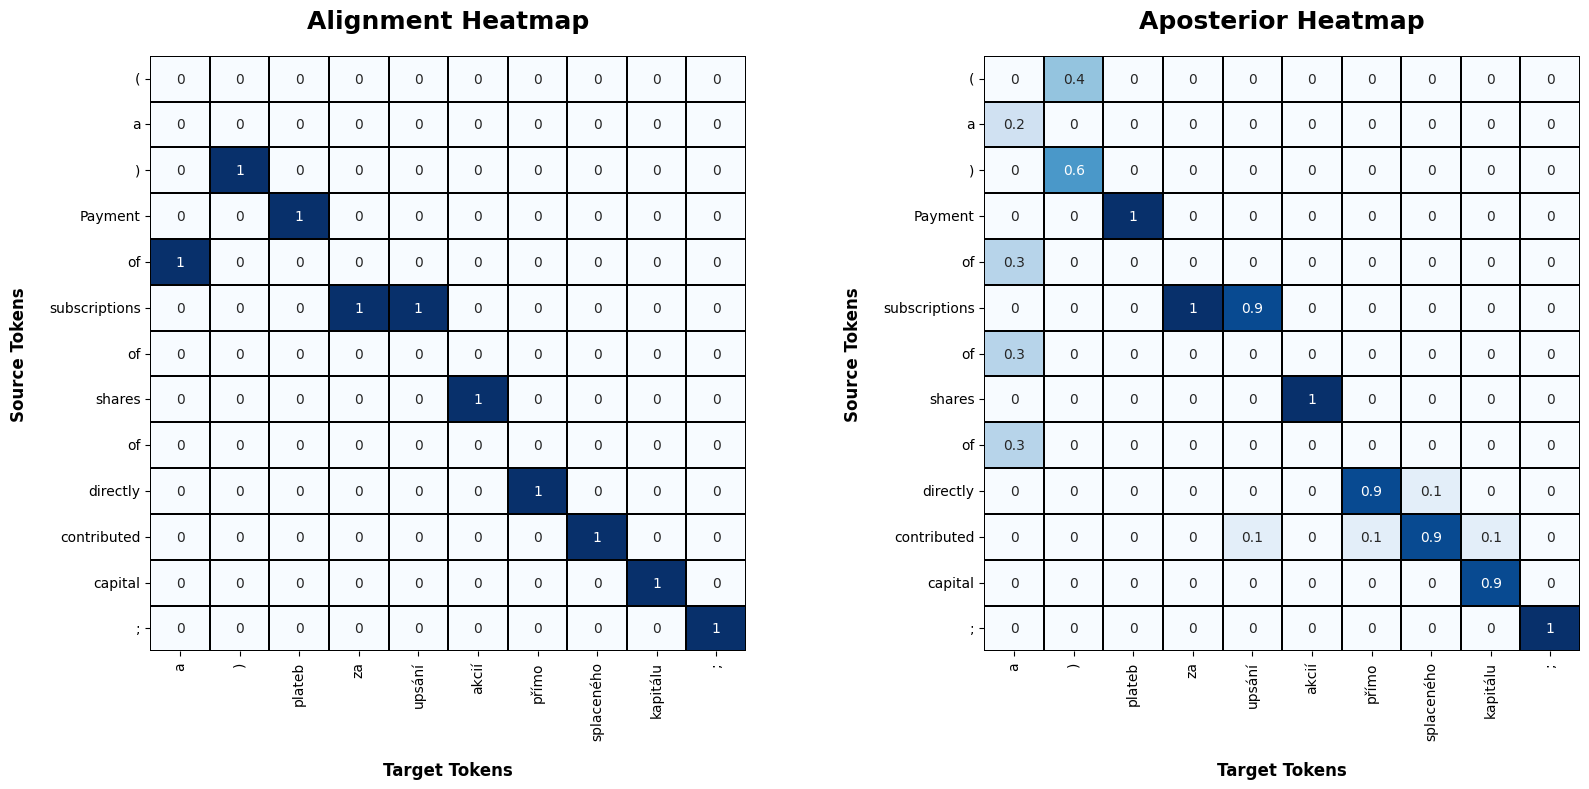

In [ ]:
plot_heatmaps(18)

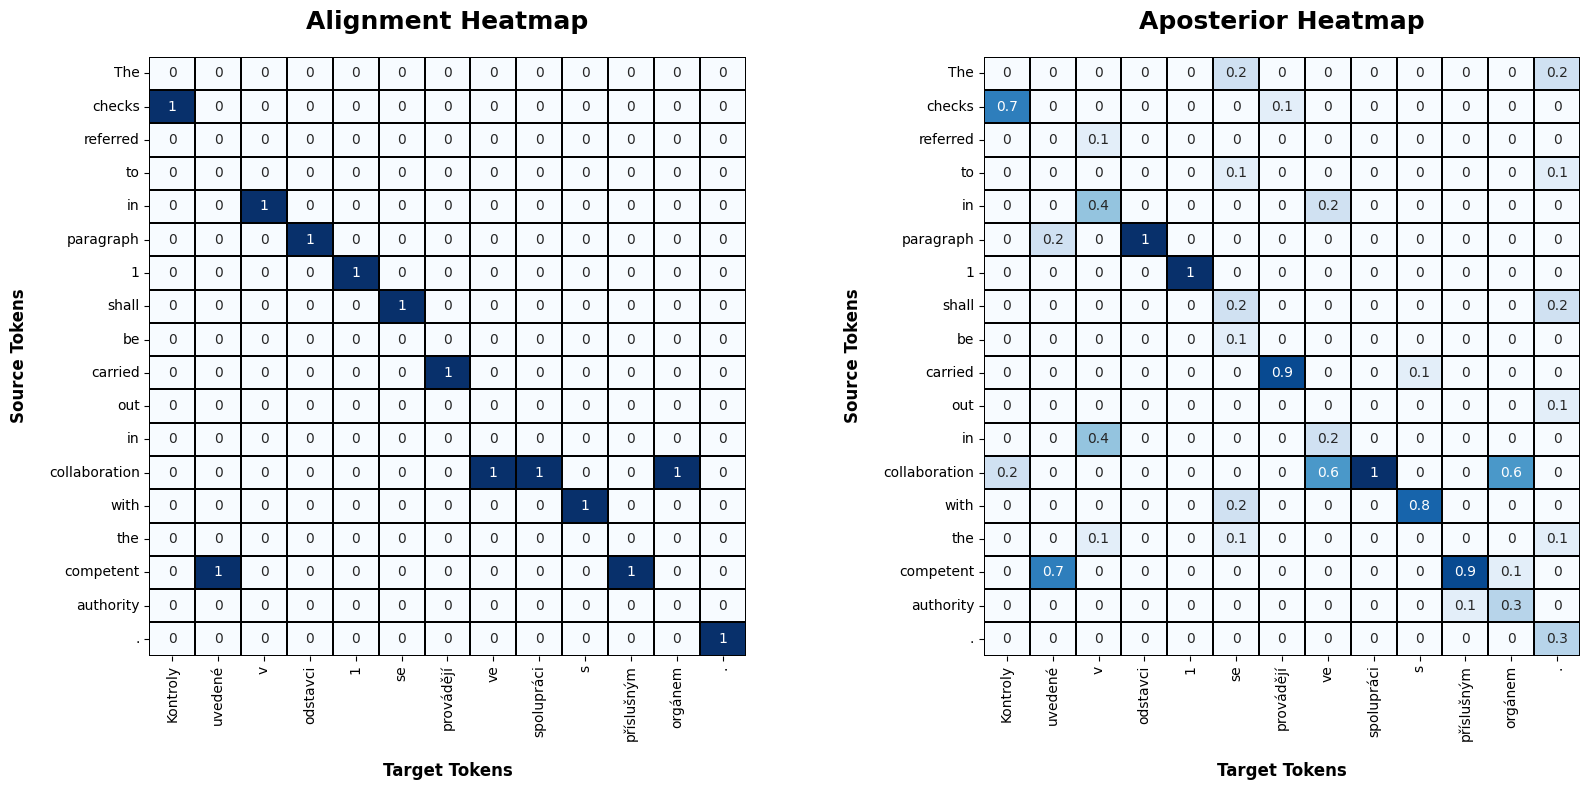

In [ ]:
plot_heatmaps(139)

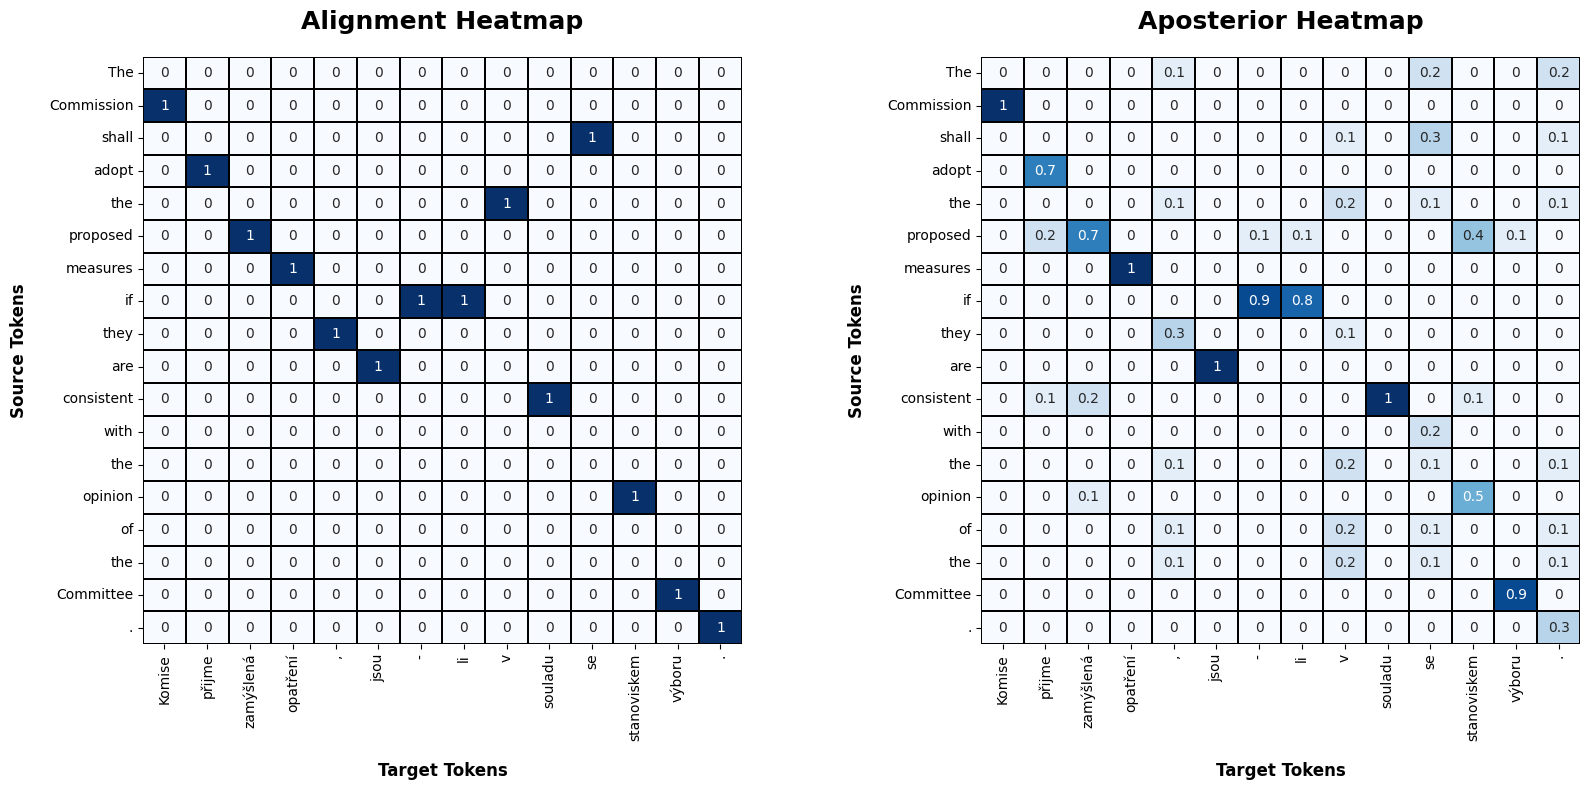

In [ ]:
plot_heatmaps(243)

**Вывод:** По графикам видно, что чаще всего слова из выравниваний стоят на одинаковых позициях в своих предложениях (# третье слово предложения из source и третье слово перевода этого предложения из target), о чем говорит нам количество закрашенных ячеек вблизи главной диагонали.

Также по правым графикам можно видеть, что в некоторых случаях модель не уверена как переводится слова из targe (# stanoviskem из предложения 243, se из предложения 139), так как в этих столбцах есть одновременно несколько ячеек, у которых вероятности близки и максимальны.

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 5. (1.5 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.

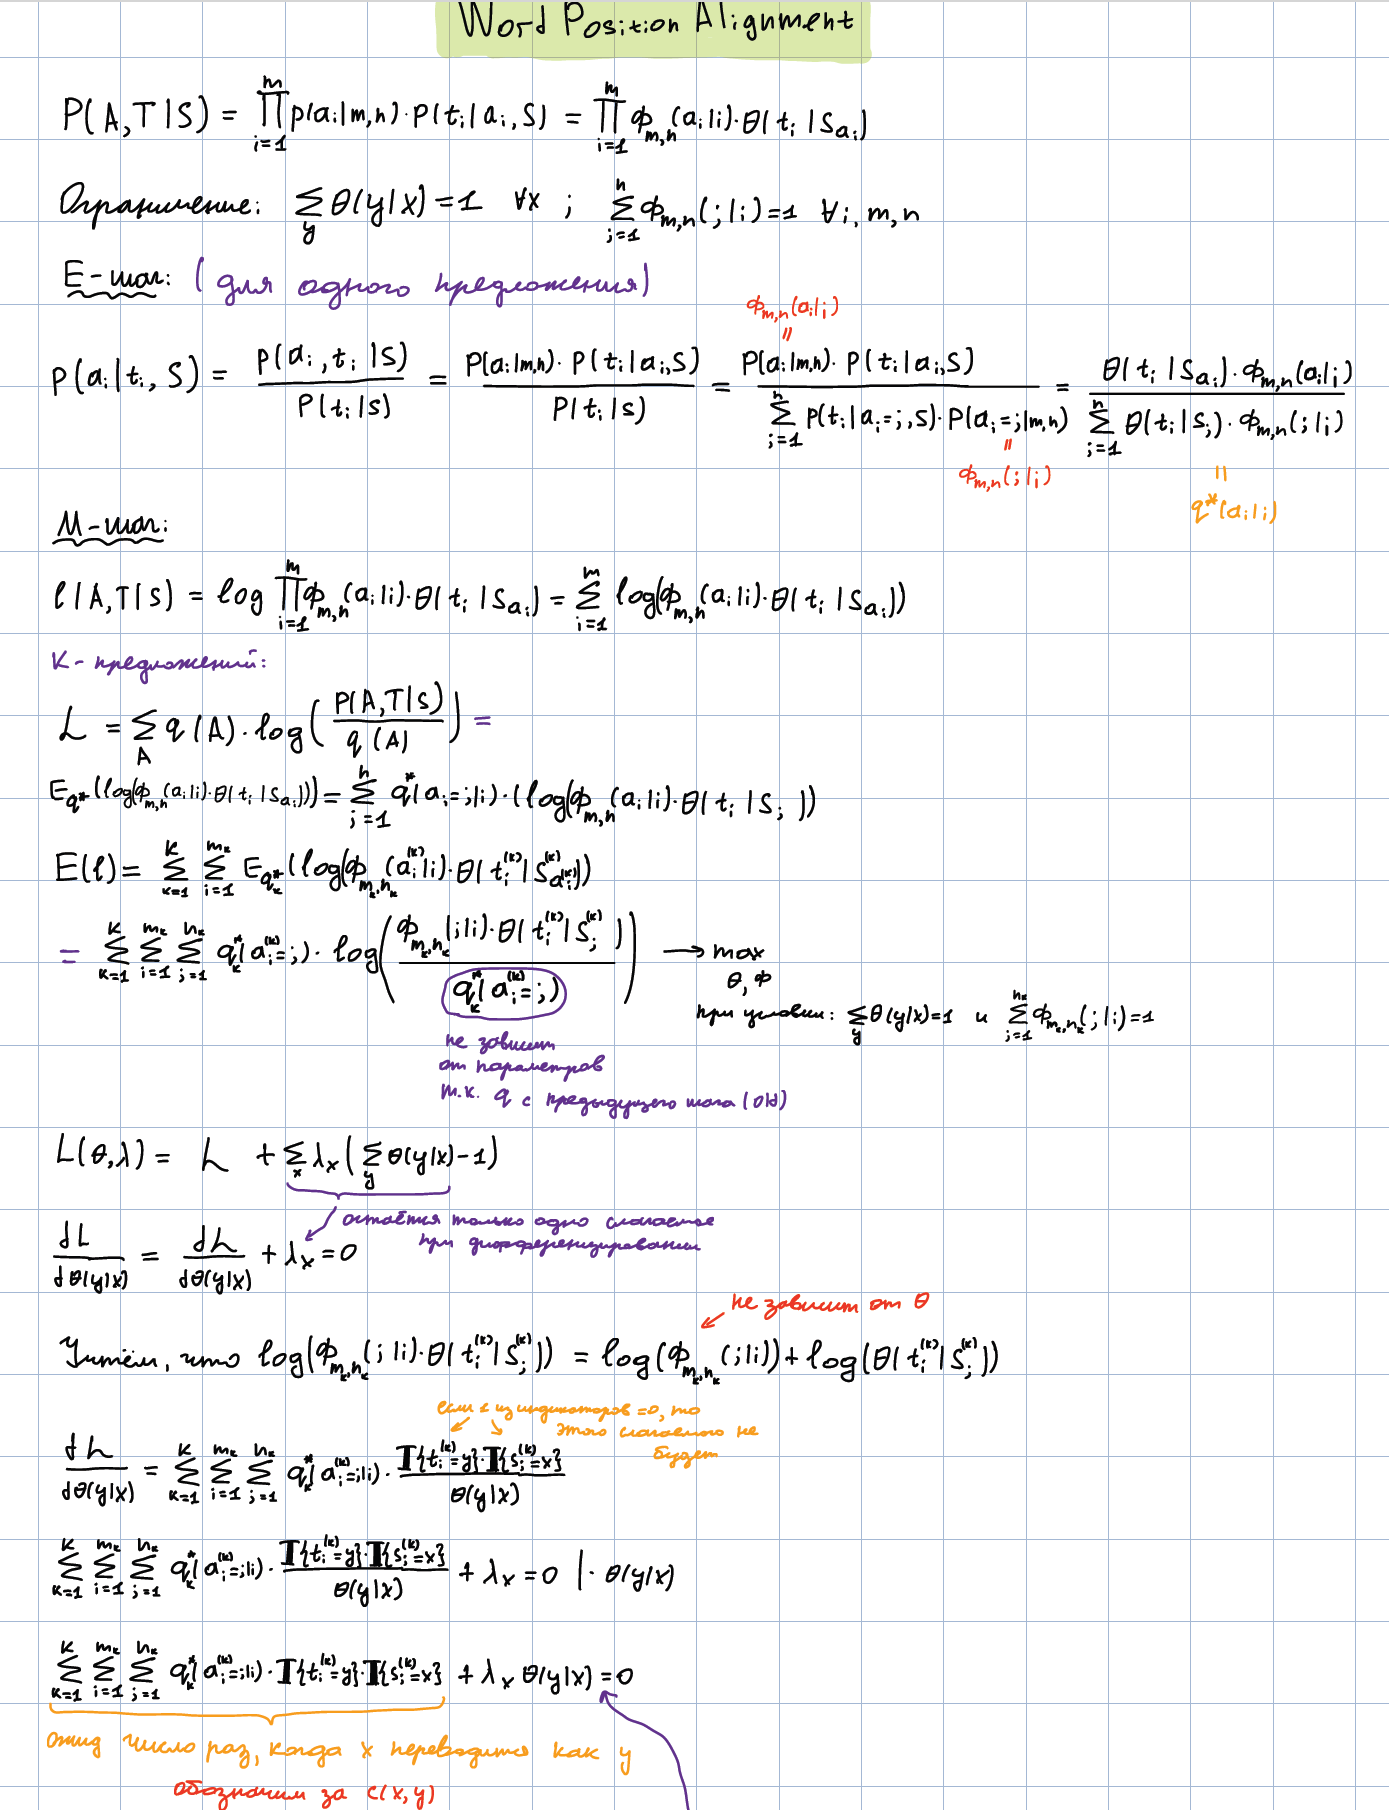

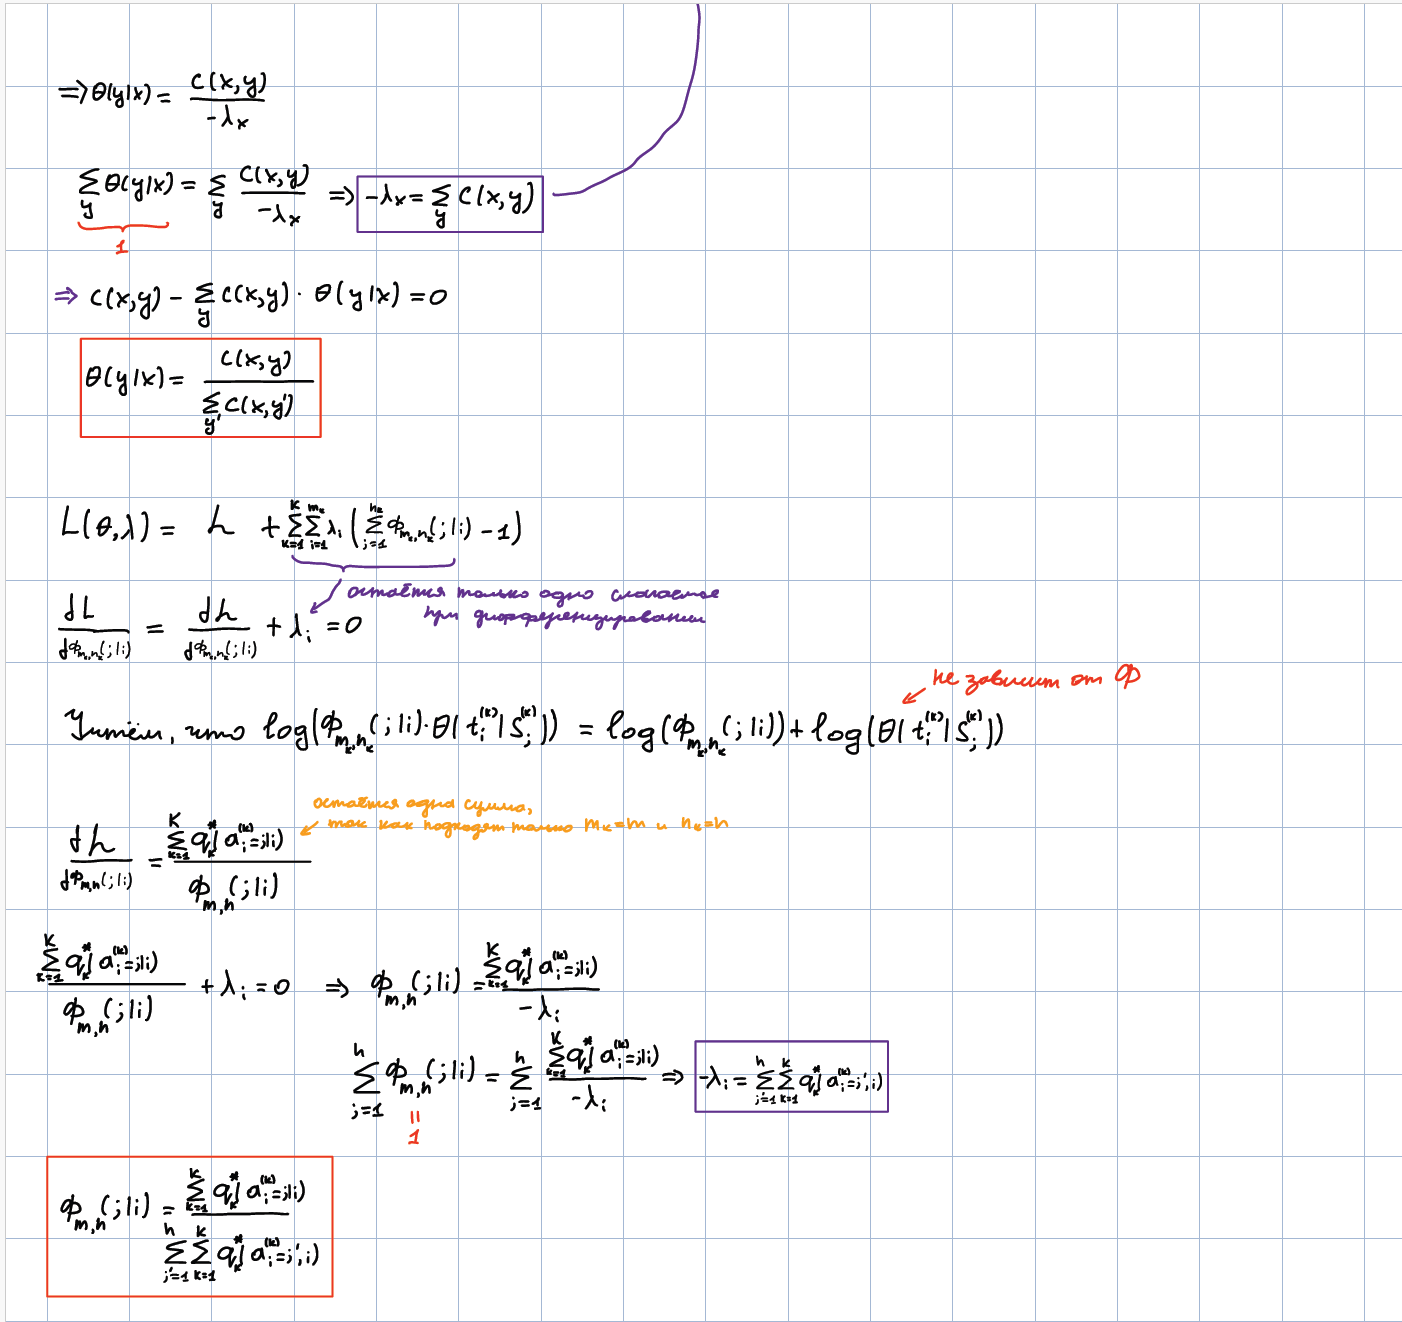

**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

https://contest.yandex.ru/contest/60281/run-report/135002742/

In [ ]:
from models import WordPositionAligner

word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 10)

start_time = time.time()
word_position_aligner.fit(tokenized_sentences)
end_time = time.time()

In [ ]:
predict_alignments = word_position_aligner.align(tokenized_sentences)
print('Время обучения (сек):', round(end_time-start_time, 2))

Время обучения (сек): 4.5


In [ ]:
compute_aer(all_targets, predict_alignments)

0.5907196443456515

**Вывод:** Получилось так, что улучшенная модель показывается результаты хуже на 0.013 :) Но обучается чуть быстрее.

Но попробуем проинициализировать стартовые параметры с помощью обычного WordAlignment. Буду использовать по 5 шагов для каждой модели, следовательно в сумме будет 10, как и во всех моделях выше.

In [ ]:
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 5)

start_time = time.time()
word_aligner.fit(tokenized_sentences)
end_time = time.time()

trained_translation_probs = word_aligner.translation_probs

In [ ]:
pretrained_word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 5)
pretrained_word_position_aligner.translation_probs = trained_translation_probs

start_time2 = time.time()
pretrained_word_position_aligner.fit(tokenized_sentences)
end_time2 = time.time()

In [ ]:
predict_alignments = pretrained_word_position_aligner.align(tokenized_sentences)
print('Время обучения (сек):', round(end_time-start_time + end_time2-start_time2, 2))

Время обучения (сек): 4.83


In [ ]:
compute_aer(all_targets, predict_alignments)

0.5548351908451936

**Вывод:** Качество улучшилось на 0.022, что довольно существенно. Из этого можно сделать вывод, что стартовые переменные значительно влияет на результат, и модель WordPositionAlignment лучше использовать совместно с обычным WordAlignment.

**Задание 7. (1 балл)** В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [ ]:
import unicodedata

def text_normalization(text: str) -> str:
    text = unicodedata.normalize('NFC', text)
    return text.lower()

**Замечание:** Ниже код из preprocessing, но с двумя изменениями.

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np


@dataclass(frozen=True)
class SentencePair:
    """
    Contains lists of tokens (strings) for source and target sentence
    """
    source: List[str]
    target: List[str]


@dataclass(frozen=True)
class TokenizedSentencePair:
    """
    Contains arrays of token vocabulary indices (preferably np.int32) for source and target sentence
    """
    source_tokens: np.ndarray
    target_tokens: np.ndarray


@dataclass(frozen=True)
class LabeledAlignment:
    """
    Contains arrays of alignments (lists of tuples (source_pos, target_pos)) for a given sentence.
    Positions are numbered from 1.
    """
    sure: List[Tuple[int, int]]
    possible: List[Tuple[int, int]]

def get_token_to_index(sentence_pairs: List[SentencePair], freq_cutoff=None) -> Tuple[Dict[str, int], Dict[str, int]]:
    """
    Given a parallel corpus, create two dictionaries token->index for source and target language.

    Args:
        sentence_pairs: list of `SentencePair`s for token frequency estimation
        freq_cutoff: if not None, keep only freq_cutoff most frequent tokens in each language

    Returns:
        source_dict: mapping of token to a unique number (from 0 to vocabulary size) for source language
        target_dict: mapping of token to a unique number (from 0 to vocabulary size) target language
    """
    source_tokens = []
    target_tokens = []

    # Нормализуем каждый токен и приводим его к нижнему регистру
    for pair in sentence_pairs:
        source_tokens.extend([text_normalization(token) for token in pair.source])
        target_tokens.extend([text_normalization(token) for token in pair.target])

    source_counted = Counter(source_tokens)
    target_counted = Counter(target_tokens)

    sorted_source_tokens = sorted(source_counted.keys(), key=lambda x: source_counted[x], reverse=True)
    sorted_target_tokens = sorted(target_counted.keys(), key=lambda x: target_counted[x], reverse=True)

    if freq_cutoff is not None:
        sorted_source_tokens = sorted_source_tokens[:freq_cutoff]
        sorted_target_tokens = sorted_target_tokens[:freq_cutoff]

    source_dict = {token: i for i, token in enumerate(sorted_source_tokens)}
    target_dict = {token: i for i, token in enumerate(sorted_target_tokens)}

    return source_dict, target_dict

def tokenize_sents(sentence_pairs: List[SentencePair], source_dict, target_dict) -> List[TokenizedSentencePair]:
    """
    Given a parallel corpus and token_to_index for each language, transform each pair of sentences from lists
    of strings to arrays of integers. If either source or target sentence has no tokens that occur in corresponding
    token_to_index, do not include this pair in the result.

    Args:
        sentence_pairs: list of `SentencePair`s for transformation
        source_dict: mapping of token to a unique number for source language
        target_dict: mapping of token to a unique number for target language

    Returns:
        tokenized_sentence_pairs: sentences from sentence_pairs, tokenized using source_dict and target_dict
    """
    tokenized_sentence_pairs = []
    removed_sentences = []
    for index, pair in enumerate(sentence_pairs):
        # Нормализуем каждый токен и приводим его к нижнему регистру
        source_tokens = [text_normalization(token) for token in pair.source]
        target_tokens = [text_normalization(token) for token in pair.target]

        source_indices = [source_dict[token] for token in source_tokens if token in source_dict]
        target_indices = [target_dict[token] for token in target_tokens if token in target_dict]

        if len(source_indices) == 0 or len(target_indices) == 0:
            removed_sentences.append(index)

        tokenized_sentence_pair = TokenizedSentencePair(
            source_tokens=np.array(source_indices),
            target_tokens=np.array(target_indices)
        )

        tokenized_sentence_pairs.append(tokenized_sentence_pair)
    return tokenized_sentence_pairs, removed_sentences

In [ ]:
t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences, removed_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

In [ ]:
removed_sentences

[]

**Замечание:** Не были удалены предложения из-за отсутствия слов в словаре, все хорошо.

In [ ]:
import time

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 10)

start_time = time.time()
word_aligner.fit(tokenized_sentences)
end_time = time.time()

predict_alignments = word_aligner.align(tokenized_sentences)
print('Время обучения (сек):', round(end_time-start_time, 2))

Время обучения (сек): 4.04


In [ ]:
compute_aer(all_targets, predict_alignments)

0.5617712739135357

**Вывод:** По сравнению с простой моделью качество улучшилось на 0.015, а время обучения снизилось на 0.7 секунды, что существенно.

In [ ]:
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 5)

start_time = time.time()
word_aligner.fit(tokenized_sentences)
end_time = time.time()

trained_translation_probs = word_aligner.translation_probs

pretrained_word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 5)
pretrained_word_position_aligner.translation_probs = trained_translation_probs\

start_time2 = time.time()
pretrained_word_position_aligner.fit(tokenized_sentences)
end_time2 = time.time()

predict_alignments = pretrained_word_position_aligner.align(tokenized_sentences)
print('Время обучения (сек):', round(end_time-start_time + end_time2-start_time2, 2))

Время обучения (сек): 4.07


In [ ]:
compute_aer(all_targets, predict_alignments)

0.5422905539604623

**Вывод:** По сравнению с лучшей моделью качество улучшилось на 0.01, а время обучения снизилось на 0.8 секунды, что также довольно значимые результаты.

Таким образом, нормализация текста и приведение его к нижнему регистру существенно улучшает качество и снижает время обучения.

**Задание 7. (бонус, до 3 баллов)**

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)

In [ ]:
# ┐_(ツ)_┌━☆ﾟ.*･｡ﾟ